In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.preprocessing import LabelEncoder
from nltk import word_tokenize

In [2]:
df=pd.read_csv('dataset.csv',usecols=['category','text'])
df.dropna()
print(df.shape)
df.head()

(2225, 2)


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [3]:
train_x,test_x,train_y,test_y=train_test_split(df['text'],df['category'],random_state=1)

le=LabelEncoder()
train_y=le.fit_transform(train_y)
test_y=le.fit_transform(test_y)
print(list(le.classes_))

['business', 'entertainment', 'politics', 'sport', 'tech']


In [4]:
tagged_data=[]
for i in tqdm(range(len(train_x))):
    tagged_data.append(TaggedDocument(word_tokenize(list(train_x)[i].lower()),[str(list(train_y)[i])]))

100%|██████████| 1668/1668 [00:07<00:00, 222.18it/s]


In [5]:
test_data=[]
for i in tqdm(range(len(test_x))):
    test_data.append(TaggedDocument(word_tokenize(list(test_x)[i].lower()),[str(list(test_y)[i])]))

100%|██████████| 557/557 [00:02<00:00, 257.51it/s]


In [6]:
model=Doc2Vec(dm=1,vector_size=100,alpha=0.025,min_alpha=0.001,min_count=2)
model.build_vocab([x for x in tagged_data])

model.train(tagged_data,epochs=10,total_examples=len(tagged_data))

In [7]:
model.save("d2v_model")

In [8]:
def genVector(model,dataset):
    target,vector=zip(*[(doc.tags[0],model.infer_vector(doc.words)) for doc in dataset])
    return target,vector

In [9]:
mod=Doc2Vec.load("d2v_model")
y_train,x_train=genVector(mod,tagged_data)
y_test,x_test=genVector(mod,test_data)

In [10]:
from sklearn.linear_model import LogisticRegression

logreg=LogisticRegression(n_jobs=1,C=1e5)
logreg.fit(x_train,y_train)
pred=logreg.predict(x_test)
print(np.mean(pred==y_test))

/home/sayantan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/sayantan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.9694793536804309


In [11]:
from keras.models import Sequential
from keras.layers import *
from keras import metrics

Using TensorFlow backend.


In [15]:
m=Sequential()
#m.add(InputLayer(input_shape=[len(x_train[0])]))
m.add(InputLayer(input_shape=[100]))
m.add(Dense(512,activation='relu'))
m.add(Dense(512,activation='relu'))
m.add(Dense(512,activation='relu'))

m.add(Dropout(0.03))
m.add(Dense(216,activation='relu'))
m.add(Dropout(0.03))
m.add(Dense(32,activation='softmax'))

m.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [16]:
hist=m.fit(x=np.array(x_train),y=np.array(y_train),epochs=20,batch_size=100,verbose=1,validation_split=0.05)

Instructions for updating:
Use tf.cast instead.
Train on 1584 samples, validate on 84 samples
Epoch 1/20
1584/1584 [==============================] - 3s 2ms/step - loss: 0.8007 - acc: 0.8883 - val_loss: 0.0160 - val_acc: 1.0000
Epoch 2/20
1584/1584 [==============================] - 1s 341us/step - loss: 0.0587 - acc: 0.9830 - val_loss: 0.0074 - val_acc: 1.0000
Epoch 3/20
1584/1584 [==============================] - 0s 312us/step - loss: 0.0630 - acc: 0.9798 - val_loss: 0.0048 - val_acc: 1.0000
Epoch 4/20
1584/1584 [==============================] - 1s 325us/step - loss: 0.0297 - acc: 0.9912 - val_loss: 0.0093 - val_acc: 1.0000
Epoch 5/20
1584/1584 [==============================] - 1s 357us/step - loss: 0.0152 - acc: 0.9962 - val_loss: 0.0122 - val_acc: 1.0000
Epoch 6/20
1584/1584 [==============================] - 1s 322us/step - loss: 0.0090 - acc: 0.9981 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 7/20
1584/1584 [==============================] - 1s 324us/step - loss: 0.0069 - acc: 

In [25]:
import pickle
from sklearn.externals import joblib

filename1='neural_model.pkl'
filename2='d2v.pkl'
filename3='logreg.pkl'

joblib.dump(model,filename2)
joblib.dump(m,filename1)
joblib.dump(logreg,filename3)

['logreg.pkl']

In [18]:
m.evaluate(np.array(x_test),np.array(y_test))

557/557 [==============================] - 0s 160us/step


[0.15342505997842298, 0.9766606822262118]

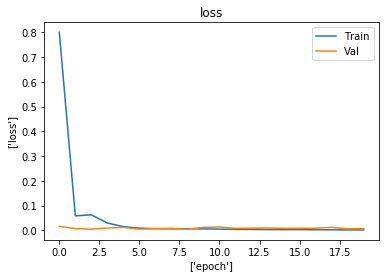

In [20]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('loss')
plt.xlabel(['epoch'])
plt.ylabel(['loss'])
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

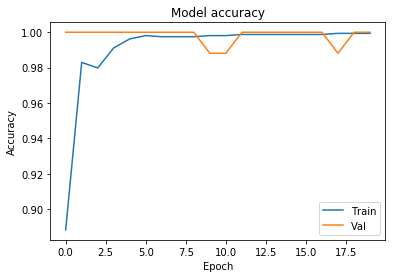

In [21]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()



In [22]:
prediction=m.predict(np.array([x_test[1]]))
result=np.argmax(prediction[0])

if(result==0):
    print('business')
if(result==1):
    print('entertainment')
if(result==2):
    print('politics')
if(result==3):
    print('sports')
if(result==4):
    print('tech')

politics


In [23]:
a=str(input())
b=word_tokenize(a.lower())
fv=model.infer_vector(b)

p=m.predict(np.array([fv]))
result=np.argmax(p[0])

if(result==0):
    print('business')
if(result==1):
    print('entertainment')
if(result==2):
    print('politics')
if(result==3):
    print('sports')
if(result==4):
    print('tech')

Do Bowling
entertainment
